# Обучение базовой модели логистической регрессии

In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('/content/drive/Shared drives/Кредитные риски')
!pip install -r CreditRisks/PythonBackend/requirements.txt

In [0]:
sys.path.append(os.path.abspath(os.path.join('.', 'CreditRisks/metrics_library')))
sys.path.append(os.path.abspath(os.path.join('.', 'CreditRisks/PythonBackend')))

In [0]:
import pandas as pd
import numpy as np
import os
import io
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import category_encoders
import matplotlib.pyplot as plt

In [0]:
from calc_model.lr_model import LRModel, Winsorizator
from feature_generation import add_features
import profits

In [0]:
DIR_IN = 'Датасеты/revision_006/'
DIR_OUT = 'Датасеты/revision_006/lr_model/'
!mkdir -p {DIR_OUT}

## Считывание данных

In [0]:
df_train = pd.read_pickle(f'{DIR_IN}companies_ready_train.pkl')
y_train = df_train['target']
x_train = df_train.drop(columns=['target'])

df_test = pd.read_pickle(f'{DIR_IN}companies_ready_test.pkl')
y_test = df_test['target']
x_test = df_test.drop(columns=['target'])

df_prod = pd.read_pickle(f'{DIR_IN}companies_ready_prod.pkl')
y_prod = df_prod['target']
x_prod = df_prod.drop(columns=['target'])

## Предобработка данных

### Добавление новых признаков

In [0]:
add_features(x_train)
add_features(x_test)
add_features(x_prod)

In [0]:
features_all = ['region', 'year_-1_1100', 'year_-1_1150', 'year_-1_1200',
       'year_-1_1210', 'year_-1_1300', 'year_-1_1310', 'year_-1_1500',
       'year_-1_1520', 'year_-1_2110', 'year_-1_2120',
       'year_-1_AssetTurnover',
       'year_-1_CoverageDebtWithAccumulatedProfit',
       'year_-1_CreditLeverage', 'year_-1_CurrentLiquidity',
       'year_-1_DebtBurden', 'year_-1_LevelOfOperatingAssets',
       'year_-1_LiabilityCoverageOperatingProfit',
       'year_-1_NetProfitMargin',
       'year_-1_OperatingProfitFinancialDebtRatio',
       'year_-1_QuickLiquidity', 'year_-1_ReturnAssetsNetProfit',
       'year_-1_okved', 'year_-1_okved1', 'year_-1_okved2',
       'year_-2_1150', 'year_-2_1200', 'year_-2_1230', 'year_-2_1310',
       'year_-2_1500', 'year_-2_1520', 'year_-2_1600', 'year_-2_2100',
       'year_-2_2110', 'year_-2_2120', 'year_-2_2300', 'year_-2_2400',
       'year_0_1100', 'year_0_1150', 'year_0_1200', 'year_0_1210',
       'year_0_1230', 'year_0_1250', 'year_0_1300', 'year_0_1310',
       'year_0_1500', 'year_0_1520', 'year_0_2300', 'year_0_2400',
       'year_0_AssetTurnover', 'year_0_CoverageDebtWithAccumulatedProfit',
       'year_0_CreditLeverage', 'year_0_DebtBurden',
       'year_0_FinancialCycle', 'year_0_InstantLiquidity',
       'year_0_LevelOfOperatingAssets',
       'year_0_LiabilityCoverageOperatingProfit',
       'year_0_NetProfitMargin',
       'year_0_OperatingProfitFinancialDebtRatio',
       'year_0_ReturnAssetsNetProfit', 'year_0_financialDebt',
       'year_0_okved', 'year_0_okved1', 'year_0_okved2',
       'year_0_turnoverCreditDebt', 'year_0_turnoverDebtorDebt',
       'year_0_turnoverReserves']
features_all = np.array(features_all)

In [0]:
with open(f'{DIR_OUT}cols.pkl', 'wb') as f:
    pickle.dump(features_all, f)

In [0]:
x_train = x_train[features_all]
x_test = x_test[features_all]
x_prod = x_prod[features_all]

### Стандартизация, винзоризация и выброс категориальных признаков

In [0]:
features_cat = ['region', ]
for year in ['-1', '0']:
    for col in ['okved', 'okved2', 'okved1', ]:
        features_cat.append(f'year_{year}_{col}')    
assert set(features_cat) & set(features_all) == set(features_cat)
features_float = np.array(sorted(list(set(features_all) - set(features_cat))))

In [0]:
catboost_encoder = category_encoders.CatBoostEncoder(cols=features_cat, random_state=42)
__x_train_cat = catboost_encoder.fit_transform(x_train[features_cat],  y_train)
__x_test_cat = catboost_encoder.transform(x_test[features_cat])

In [0]:
catboost_encoder_prod = category_encoders.CatBoostEncoder(cols=features_cat, random_state=42)
__x_prod_cat = catboost_encoder_prod.fit_transform(x_prod[features_cat],  y_prod)

In [0]:
sc = StandardScaler()
winz = Winsorizator(0.3, 0.7)

In [0]:
__x_train_float = x_train[features_float].copy()
winz.fit_transform(__x_train_float)
__x_train = pd.concat([__x_train_float, __x_train_cat], axis=1)
__x_train = pd.DataFrame(sc.fit_transform(__x_train), columns=__x_train.columns, index=__x_train.index)

__x_test_float = x_test[features_float].copy()
winz.transform(__x_test_float)
__x_test = pd.concat([__x_test_float, __x_test_cat], axis=1)
__x_test = pd.DataFrame(sc.transform(__x_test), columns=__x_test.columns, index=__x_test.index)

In [0]:
sc_prod = StandardScaler()
winz_prod = Winsorizator(0.3, 0.7)

In [0]:
__x_prod_float = x_prod[features_float].copy()
winz_prod.fit_transform(__x_prod_float)
__x_prod = pd.concat([__x_prod_float, __x_prod_cat], axis=1)
__x_prod = pd.DataFrame(sc_prod.fit_transform(__x_prod), columns=__x_prod.columns, index=__x_prod.index)

## Обучение

In [0]:
def plt_to_bytes():
    b = io.BytesIO()
    plt.savefig(b, format="png")
    b.seek(0)
    return b.read()

In [0]:
def measure_quality(y_true: np.array, y_predict: np.array, name=None):
    print("ROC AUC: ", roc_auc_score(y_true, y_predict))
    plts = {}
    profits.plt_profit(y_true,  y_predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title=name)
    plts['plt_profit'] = plt_to_bytes()
    profits.plt_profit_recall(y_true,  y_predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title=name)
    plts['plt_profit_recall'] = plt_to_bytes()
    profits.plt_popularity(y_predict, title=name) 
    plts['plt_popularity'] = plt_to_bytes()
    return plts

In [21]:
lr = LogisticRegression(random_state=42, verbose=1, max_iter=1000).fit(__x_train, y_train)
predict = lr.predict_proba(__x_test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s finished


ROC AUC:  0.6787182766000925


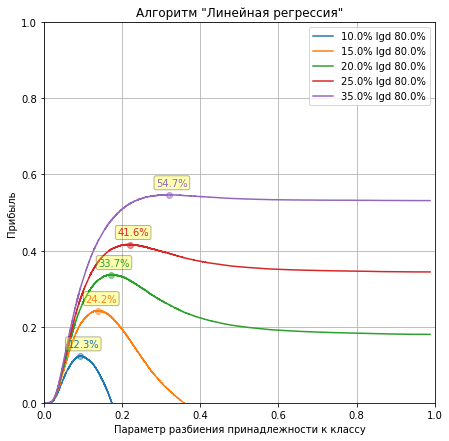

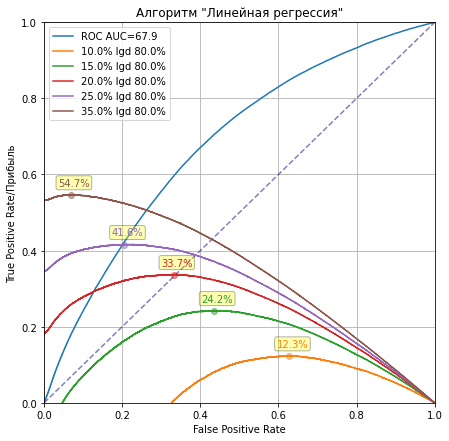

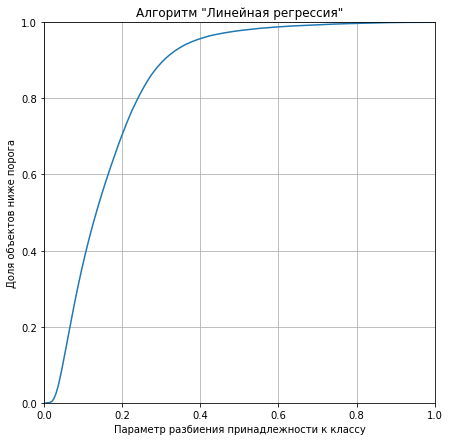

In [22]:
plts = measure_quality(y_test, predict, name='Алгоритм "Линейная регрессия"')

In [0]:
super_lr = LRModel("Линейная регрессия", plts, features_all, np.array(features_cat), catboost_encoder, winz, sc, lr)
with open(f'{DIR_OUT}model_train.pkl','wb') as f:
    pickle.dump(super_lr, f)

# Модель на Production

In [24]:
lr_prod = LogisticRegression(random_state=42, verbose=1, max_iter=1000).fit(__x_prod, y_prod)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s finished


In [0]:
super_lr_prod = LRModel("Линейная регрессия", plts, features_all, np.array(features_cat), catboost_encoder_prod, winz_prod, sc_prod, lr_prod)
with open(f'{DIR_OUT}model_prod.pkl','wb') as f:
    pickle.dump(super_lr_prod, f)